In [24]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import numpy as np
import matplotlib

# **The Generator Model**

In [25]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            # nz will be the input to the first convolution
            nn.ConvTranspose2d(
                nz, 512, kernel_size=4, 
                stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(
                512, 256, kernel_size=4, 
                stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(
                256, 128, kernel_size=4, 
                stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(
                128, 64, kernel_size=4, 
                stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(
                64, 3, kernel_size=4, 
                stride=2, padding=1, bias=False),
            nn.Tanh()
        )
    def forward(self, input):
        return self.main(input)


# **Explanation**

In __init__() function, you will notice that we have the nz parameter. We initialize this as self.nz. This is the size of the noise vector that the generator will use as the input. You will also see the 100-dimensional noise vector as the input to the generator.
We use the Sequential container to build the generator model.
The size of in_channels for the first convolutional layer is self.n which is equal to 100. The out_channels is 512 and the kernel size of 4×4. For the first convolutional layer, we have a stride of 1 and a padding of 0. Then we have the batch normalization and the ReLU activation function.
After that, we have four such convolutional blocks.
With each subsequent convolution operation, we keep on reducing the output channels. We start from 512 output channels and have 3 output channels after the last convolution operation. 512 => 256 => 128 => 64 => 3. This 3 refers to the three channels (RGB) of the colored images.
All of the four convolutions have a stride of 2 and a padding of 1 with 4×4 kernel.
Only the last convolution operation has Tanh activation instead of ReLU. Also, the final image dimension generated by the generator is going to be 64x64x3.
The forward() function makes a forward pass of the noise vector through the generator network. It returns the generated output.

# **The Discriminator Model**

In [26]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(
                3, 64, kernel_size=4, 
                stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(
                64, 128, kernel_size=4, 
                stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(
                128, 256, kernel_size=4, 
                stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(
                256, 512, kernel_size=4, 
                stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(
                512, 1, kernel_size=4, 
                stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, input):
        return self.main(input)

# **Explanation**

We are using the Sequential container just as we did in the case of the generator.
There are five convolution operations in the discriminator model as well.
The first convolution operation has three in_channels which corresponds to the three color channels of the CIFAR10 images. The out_channels is 64. The kernel size is 4×4, the stride is 2 and padding is 1. We do not have any batch normalization after the first convolution operation. The LeakyReLU activation has a slope of 0.2, as discussed previously.
The following three convolution operations are very similar. The output channels keep on increasing till 512 out_channels in the fourth Conv2d(). But we are implementing batch normalization after these three convolution operations.
The last convolution operation has 1 output channel with Sigmoid activation. This is because we need the discriminator to classify whether an image is real (1) or fake (0). As this is binary classification, therefore, we are using Sigmoid activation. The stride here is 1 and padding is 0.
The forward() function forward passes either the real image or fake image batch through the discriminator network. Then the discriminator returns the binary classifications.

# **Device initialization**

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [28]:
!lscpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               79
Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz
Stepping:            0
CPU MHz:             2200.000
BogoMIPS:            4400.00
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            56320K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_sin

# **Functions for Creating Fake and Real Labels**


In [29]:
def label_real(size):
    """
    Fucntion to create real labels (ones)
    :param size: batch size
    :return real label vector
    """
    data = torch.ones(size, 1)
    return data.to(device)
def label_fake(size):
    """
    Fucntion to create fake labels (zeros)
    :param size: batch size
    :returns fake label vector
    """
    data = torch.zeros(size, 1)
    return data.to(device)

# **Creating noise tensor**

In [30]:
def create_noise(sample_size, nz):
    """
    Fucntion to create noise
    :param sample_size: fixed sample size or batch size
    :param nz: latent vector size
    :returns random noise vector
    """
    return torch.randn(sample_size, nz, 1, 1).to(device)    # returns a tensor of size [sample_size, nz, 1, 1]

In [31]:
from torchvision.utils import save_image

def save_generator_image(image, path):
    """
    Function to save torch image batches
    :param image: image tensor batch
    :param path: path name to save image
    """
    save_image(image, path, normalize=True)

# **Weight Initialization**

From the DCGAN paper, the authors specify that all model weights shall be randomly initialized from a Normal distribution with mean=0, stdev=0.02. The weights_init function takes an initialized model as input and reinitializes all convolutional, convolutional-transpose, and batch normalization layers to meet this criteria. This function is applied to the models immediately after initialization.

In [32]:
def weights_init(m):
    """
    This function initializes the model weights randomly from a 
    Normal distribution. This follows the specification from the DCGAN paper.
    https://arxiv.org/pdf/1511.06434.pdf
    Source: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

*Importing additional stuff*

In [33]:
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm

matplotlib.style.use('ggplot')

# **Defining some inputs according to the reccomendation by the DCGAN paper**

*batch_size* - the batch size used in training. The DCGAN paper uses a batch size of 128
*image_size* - the spatial size of the images used for training. This implementation defaults to 64x64. If another size is desired, the structures of D and G must be changed. See here for more details
*nc* - number of color channels in the input images. For color images this is 3
*nz* - length of latent vector
*num_epochs* - number of training epochs to run. Training for longer will probably lead to better results but will also take much longer
*lr* - learning rate for training. As described in the DCGAN paper, this number should be 0.0002
*beta*1 - beta1 hyperparameter for Adam optimizers. As described in paper, this number should be 0.5

In [34]:
# learning parameters / configurations according to paper
image_size = 64 # we need to resize image to 64x64
batch_size = 128
nz = 100 # latent vector size
beta1 = 0.5 # beta1 value for Adam optimizer
lr = 0.0002 # learning rate according to paper
sample_size = 64 # fixed sample size
epochs = 25 # number of epoch to train
# set the computation device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# **Preparing the Dataset**
We will use the datasets module from torchvision to download the CIFAR10 dataset. Before downloading the dataset, let’s define the image transforms.

In [35]:
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), 
    (0.5, 0.5, 0.5)),
])

Now, we will define the training data and the training data loader. We will just need the training data loader and not the validation data loader. This is because all of the DCGAN operations will happen on the training data only. This includes the fake data generation and the binary classification by the discriminator.

In [36]:
train_data = datasets.CIFAR10(
    root='../input/data',
    train=True,
    download=True,
    transform=transform
)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

Files already downloaded and verified


# **Initialize the Generator and Discriminator Networks**

In [37]:
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device) 

In [38]:
generator.apply(weights_init)
# initialize discriminator weights
discriminator.apply(weights_init)
print('##### GENERATOR #####')
print(generator)
print('######################')
print('\n##### DISCRIMINATOR #####')
print(discriminator)
print('######################')

##### GENERATOR #####
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
 

# **Defining the Optimizer and Loss Function**

In [39]:
optim_g = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optim_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
# loss function
criterion = nn.BCELoss()

In [40]:
losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch

# **Function to Train the Discriminator**

In [41]:
def train_discriminator(optimizer, data_real, data_fake):
    b_size = data_real.size(0)
    # get the real label vector
    real_label = label_real(b_size)
    # get the fake label vector
    fake_label = label_fake(b_size)
    optimizer.zero_grad()
    # get the outputs by doing real data forward pass
    output_real = discriminator(data_real).view(-1)
    output_real = output_real.unsqueeze(1)
    loss_real = criterion(output_real, real_label)
    # get the outputs by doing fake data forward pass
    output_fake = discriminator(data_fake).view(-1)
    output_fake = output_fake.unsqueeze(1)
    loss_fake = criterion(output_fake, fake_label)
    # compute gradients of real loss 
    loss_real.backward()
    # compute gradients of fake loss
    loss_fake.backward()
    # update discriminator parameters
    optimizer.step()
    return loss_real + loss_fake

The function has three input parameters. The discriminator optimizer, the real data, and the fake data.
First, we get the real labels and fake labels according to the batch size.
We get the outputs by doing a forward pass of the real data through the discriminator. Calculate the loss for the real outputs and real labels.
The outputs from the fake data by doing a forward pass through the discriminator network. Calculates the loss from the fake outputs and the fake labels.
Then we compute the gradients of the real and fake losses. We update the parameters and finally return the total loss.

In [42]:
def train_generator(optimizer, data_fake):
    b_size = data_fake.size(0)
    # get the real label vector
    real_label = label_real(b_size)
    optimizer.zero_grad()
    # output by doing a forward pass of the fake data through discriminator
    output = discriminator(data_fake).view(-1)
    output = output.unsqueeze(1)
    loss = criterion(output, real_label)
    # compute gradients of loss
    loss.backward()
    # update generator parameters
    optimizer.step()
    return loss 

The train_generator() function has only two parameters. One is the generator optimizer and the other one is the fake data (data_fake).
We get the real labels.
Then we forward pass the fake data through the discriminator at line 10 and get the loss values.
Then we compute the gradients of the loss and update the generator parameters.
Finally, we return the generator loss

In [43]:
noise = create_noise(sample_size, nz)

This function takes two input parameters. One is the sampel_size which is fixed to 64. The other one is nz which is the dimension of the noise vector. Now, remember that the noise vector is 100 dimensional. We will define this later in this article as well.
So, if you print the size of the noise vector, then you get the following output.
[64, 100, 1, 1].

In [44]:
generator.train()
discriminator.train()

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [46]:
for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        image, _ = data
        image = image.to(device)
        b_size = len(image)
        # forward pass through generator to create fake data
        data_fake = generator(create_noise(b_size, nz)).detach()
        data_real = image
        loss_d += train_discriminator(optim_d, data_real, data_fake)
        data_fake = generator(create_noise(b_size, nz))
        loss_g += train_generator(optim_g, data_fake)
    # final forward pass through generator to create fake data...
    # ...after training for current epoch
    generated_img = generator(noise).cpu().detach()
    # save the generated torch tensor models to disk
    save_generator_image(generated_img, f"/content/drive/MyDrive/Colab Notebooks/outputs/gen_img{epoch}.png")
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)
    print(f"Epoch {epoch+1} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

391it [01:34,  4.13it/s]
  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 1 of 25
Generator loss: 4.25469732, Discriminator loss: 0.62929219


391it [01:34,  4.15it/s]
  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 2 of 25
Generator loss: 3.90161061, Discriminator loss: 0.59422183


391it [01:34,  4.14it/s]
  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 3 of 25
Generator loss: 3.73105288, Discriminator loss: 0.67638421


391it [01:33,  4.17it/s]
  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 4 of 25
Generator loss: 3.23461676, Discriminator loss: 0.66240323


391it [01:34,  4.16it/s]
  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 5 of 25
Generator loss: 2.80538726, Discriminator loss: 0.73595315


391it [01:34,  4.13it/s]
  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 6 of 25
Generator loss: 2.66288185, Discriminator loss: 0.82867622


391it [01:34,  4.13it/s]
  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 7 of 25
Generator loss: 2.69761467, Discriminator loss: 0.76576149


391it [01:34,  4.16it/s]
  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 8 of 25
Generator loss: 3.01912785, Discriminator loss: 0.68450999


391it [01:34,  4.15it/s]
  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 9 of 25
Generator loss: 3.17005157, Discriminator loss: 0.63768417


391it [01:34,  4.16it/s]
  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 10 of 25
Generator loss: 3.27071691, Discriminator loss: 0.56550044


391it [01:33,  4.16it/s]
  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 11 of 25
Generator loss: 2.97385931, Discriminator loss: 0.68175507


391it [01:34,  4.16it/s]
  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 12 of 25
Generator loss: 2.97598124, Discriminator loss: 0.73978347


391it [01:33,  4.16it/s]
  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 13 of 25
Generator loss: 3.02640986, Discriminator loss: 0.70619518


391it [01:33,  4.16it/s]
  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 14 of 25
Generator loss: 3.53244066, Discriminator loss: 0.53333187


391it [01:33,  4.16it/s]
  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 15 of 25
Generator loss: 2.95231152, Discriminator loss: 0.70511299


391it [01:33,  4.16it/s]
  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 16 of 25
Generator loss: 3.35808110, Discriminator loss: 0.57322741


391it [01:33,  4.16it/s]
  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 17 of 25
Generator loss: 3.90458941, Discriminator loss: 0.54254067


391it [01:33,  4.16it/s]
  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 18 of 25
Generator loss: 2.74362326, Discriminator loss: 0.72572094


391it [01:33,  4.17it/s]
  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 19 of 25
Generator loss: 3.85379744, Discriminator loss: 0.47062153


391it [01:33,  4.17it/s]
  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 20 of 25
Generator loss: 3.80757785, Discriminator loss: 0.54561716


391it [01:33,  4.16it/s]
  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 21 of 25
Generator loss: 3.43001127, Discriminator loss: 0.54904765


391it [01:34,  4.16it/s]
  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 22 of 25
Generator loss: 4.16846704, Discriminator loss: 0.39741412


391it [01:33,  4.16it/s]
  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 23 of 25
Generator loss: 3.42492104, Discriminator loss: 0.58808923


391it [01:33,  4.17it/s]
  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 24 of 25
Generator loss: 3.22645903, Discriminator loss: 0.64839298


391it [01:33,  4.17it/s]


Epoch 25 of 25
Generator loss: 3.56657410, Discriminator loss: 0.57511860


We define loss_g and loss_d to keep track of the batch-wise loss values of the generator and discriminator respectively.
Starting, we iterate through the batches in one epoch of training data.
The fake data from the generator. We use this fake data for discriminator and generator training at line 11 and 13.
The generator creates the fake data after training completes for the current epoch. This is the image that we save to disk.
We calculate the epoch-wise losses. Then we append them to losses_g and losses_d

In [48]:
print('DONE TRAINING')
# save the model weights to disk
torch.save(generator.state_dict(), '../outputs')

DONE TRAINING


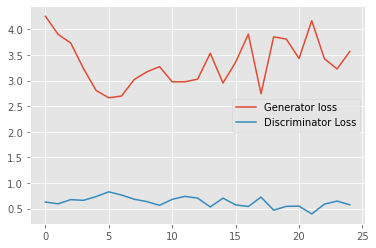

In [49]:
plt.figure()
plt.plot(losses_g, label='Generator loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/outputs/loss.png')
plt.show()